# Computing causal Shapley values

Here we show how to create a Causal Shapley masker to retrieve causal Shapley values using SHAP.

In [1]:
import xgboost

import shap
from shap.maskers._tabular import Causal as CausalMasker

First, we gather our data set and train a model to perform causal SHAP on.

In [2]:
# Retrieve a dataset
X, y = shap.datasets.adult()

In [3]:
# Train any model
model = xgboost.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

To instantiate the causal masker, which samples from the interventional or causal distribution, we provide an ordering and specify confounding.

The (partial) ordering defines causal dependencies as a nested 2D list, where each group contains causally related features. Each group depends on its predecessors. For example, in `ordering = [['Age'], ['Occupation', 'Relationship'], ['Capital Gain']]`, Occupation and Relationship depend on Age, and Capital Gain depends on all prior groups.

Confounding is a 1D Boolean array matching the number of groups in the ordering. A value of True indicates confounding within the group, making its features independent. Whereas a False preserves causal relationships. For instance, with `confounding = [True, True, False]`, Occupation and Relationship are treated as independent of eachother.


In [4]:
# Define the causal masker
ordering = [["Age"], ["Occupation", "Relationship"], ["Capital Gain"]]
confounding = [True, True, False]
causal_masker = CausalMasker(X, ordering=ordering, confounding=confounding)

We then select an explainer and provide the causal masker as an argument. Any explainer compatible with tabular maskers (ExactExplainer, PermutationExplainer, ...) should be compatible. The explainer will utilize the masker to retrieve its background data, which will now be sampled from the causal interventional distribution, adhering to the previously defined ordering.

In [5]:
# Build a Permutation explainer, although we can use any explainer that takes in a masker
explainer = shap.explainers.PermutationExplainer(model.predict_proba, causal_masker)

PermutationExplainer explainer: 101it [00:18,  2.53it/s]                         


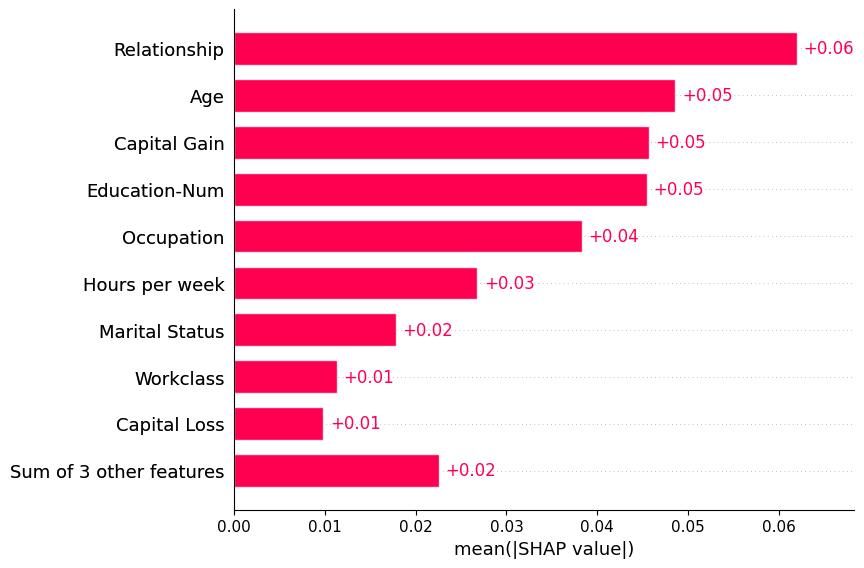

In [6]:
# Explain the model predictions on the given dataset
shap_values = explainer(X[:100])

# Get just the explanations for the positive class and plot
shap_values = shap_values[..., 1]
shap.plots.bar(shap_values)